In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coffee-scrap-coffeereview/slug.csv
/kaggle/input/coffee-scrap-coffeereview/coffee_clean.csv
/kaggle/input/coffee-scrap-coffeereview/coffee_list.csv


In [2]:
#import according libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
import re
import fuzzywuzzy
from fuzzywuzzy import process

In [3]:
df = pd.read_csv('/kaggle/input/coffee-scrap-coffeereview/coffee_clean.csv')

In [4]:
#Let's explore the data
df.head()

,slug,all_text,rating,roaster,name,location,origin,roast,est_price,review_date,agtron,aroma,acid,body,flavor,aftertaste,with_milk,desc_1,desc_2,desc_3
0,https://www.coffeereview.com/review/kenya-nyer...,\n\n\n93\n\n\nLu's Coffee\nKenya Nyeri Gichat...,93,Lu's Coffee,Kenya Nyeri Gichathaini AA Top,"New Taipei City, Taiwan","Nyeri growing region, south-central Kenya",Medium-Light,NT $320/200 grams,October 2023,58/78,9.0,9.0,8.0,9.0,8.0,NaN,"Richly sweet-savory. Red currant, narcissus, t...",Produced by smallholding members of the Gikand...,"A deep-toned, sweetly savory Kenya cup with in..."
1,https://www.coffeereview.com/review/wilton-ben...,\n\n\n96\n\n\nJBC Coffee Roasters\nWilton Ben...,96,JBC Coffee Roasters,Wilton Benitez Java,"Madison, Wisconsin","Piendamó, Cauca, Colombia",Medium-Light,$25.00/8 ounces,October 2023,60/74,9.0,9.0,9.0,10.0,9.0,NaN,"Multi-layered, enigmatic. Tart citrus, myrrh, ...",Produced by Wilton Benitez entirely of the Eth...,"An impossibly complex, delightfully floral car..."
2,https://www.coffeereview.com/review/holy-melod...,\n\n\n94\n\n\nHWC Coffee Roasters\nHWC Holy M...,94,HWC Coffee Roasters,HWC Holy Melody Espresso Blend,"Taichung, Taiwan",Kenya; Ethiopia,Medium-Light,$40.00/8 ounces,September 2023,57/77,9.0,NaN,9.0,9.0,8.0,9.0,"Evaluated as espresso. Deeply sweet-savory, fr...","A blend of coffees from Kenya and Ethiopia, ro...","A complex, multi-layered espresso blend with n..."
3,https://www.coffeereview.com/review/power-drum...,\n\n\n93\n\n\nHWC Coffee Roasters\nHWC Power ...,93,HWC Coffee Roasters,HWC Power Drum Espresso Blend,"Taichung, Taiwan","Peru, Guatemala",Medium-Light,$40.00/8 ounces,September 2023,58/73,8.0,NaN,9.0,9.0,8.0,9.0,"Evaluated as espresso. Richly chocolaty, sweet...","A blend of coffees from Peru and Guatemala, ro...","A bold, chocolaty espresso blend supported by ..."
4,https://www.coffeereview.com/review/el-salvado...,\n\n\n92\n\n\nSpeedwell Coffee\nEl Salvador M...,92,Speedwell Coffee,El Salvador Monte Verde,"Plymouth, Massachusetts","Monte Verde, Santa Ana Department, central El ...",Medium-Light,$16.00/12 ounces,September 2023,60/76,8.0,9.0,8.0,9.0,8.0,NaN,"Sweetly bright, rich-toned. Baking chocolate, ...",Produced by Rene Contreras on the family farm ...,A solid El Salvador cup with a crisp chocolate...


From the column names, it is clear to indicate columns' meanings except agtron.
From Google: [The Agtron®](https://boxercoffee.com/pages/agtron-numbers#:~:text=The%20Agtron%C2%AE%20is%20a,number%2C%20the%20lighter%20the%20roast.) is a spectrophotometer which uses infrared light to determine roast degree. <span style="color:green;">**The higher the Agtron number, the lighter the roast.**</span>

In [5]:
df.dtypes

slug            object
all_text        object
rating           int64
roaster         object
name            object
location        object
origin          object
roast           object
est_price       object
review_date     object
agtron          object
aroma          float64
acid           float64
body           float64
flavor         float64
aftertaste     float64
with_milk      float64
desc_1          object
desc_2          object
desc_3          object
dtype: object

In [6]:
#Let's see how many Nan values are there for each column:
df.isna().sum()

slug              0
all_text          0
rating            0
roaster           0
name              0
location          0
origin            0
roast            58
est_price         6
review_date       0
agtron            0
aroma            13
acid            314
body              1
flavor            1
aftertaste        1
with_milk      2115
desc_1            1
desc_2            0
desc_3            1
dtype: int64

In [7]:
df["aroma"].value_counts()
df["acid"].value_counts()
df["body"].value_counts()
df["flavor"].value_counts()

flavor
9.0     2139
8.0      188
10.0     100
7.0       11
6.0        1
Name: count, dtype: int64

Most of the ratings within the colunmns; aroma, acid, body, flavor are 9.0 and those ratings seem like not providing a wide range for comparison. 

Now we have a little idea about this dataset, we can decide what to keep and not to keep. As we saw above, dozens of rows in with_milk contains NaN value, we can drop this column since we do not need it. More, most of the ratings within the colunmns; aroma, acid, body, flavor are 9.0 and those ratings seem like not providing a wide range for comparison. So we will drop those also

In [8]:
df = df.drop(["with_milk", "aroma", "acid", "body", "flavor", "aftertaste", "slug", "all_text"], axis = 1)

In [9]:
#Let's check our dataset again
df.head()

,rating,roaster,name,location,origin,roast,est_price,review_date,agtron,desc_1,desc_2,desc_3
0,93,Lu's Coffee,Kenya Nyeri Gichathaini AA Top,"New Taipei City, Taiwan","Nyeri growing region, south-central Kenya",Medium-Light,NT $320/200 grams,October 2023,58/78,"Richly sweet-savory. Red currant, narcissus, t...",Produced by smallholding members of the Gikand...,"A deep-toned, sweetly savory Kenya cup with in..."
1,96,JBC Coffee Roasters,Wilton Benitez Java,"Madison, Wisconsin","Piendamó, Cauca, Colombia",Medium-Light,$25.00/8 ounces,October 2023,60/74,"Multi-layered, enigmatic. Tart citrus, myrrh, ...",Produced by Wilton Benitez entirely of the Eth...,"An impossibly complex, delightfully floral car..."
2,94,HWC Coffee Roasters,HWC Holy Melody Espresso Blend,"Taichung, Taiwan",Kenya; Ethiopia,Medium-Light,$40.00/8 ounces,September 2023,57/77,"Evaluated as espresso. Deeply sweet-savory, fr...","A blend of coffees from Kenya and Ethiopia, ro...","A complex, multi-layered espresso blend with n..."
3,93,HWC Coffee Roasters,HWC Power Drum Espresso Blend,"Taichung, Taiwan","Peru, Guatemala",Medium-Light,$40.00/8 ounces,September 2023,58/73,"Evaluated as espresso. Richly chocolaty, sweet...","A blend of coffees from Peru and Guatemala, ro...","A bold, chocolaty espresso blend supported by ..."
4,92,Speedwell Coffee,El Salvador Monte Verde,"Plymouth, Massachusetts","Monte Verde, Santa Ana Department, central El ...",Medium-Light,$16.00/12 ounces,September 2023,60/76,"Sweetly bright, rich-toned. Baking chocolate, ...",Produced by Rene Contreras on the family farm ...,A solid El Salvador cup with a crisp chocolate...


After dropping the irrelevant columns, let's see how much data we have

In [10]:
print(f"The length of the dataframe: {len(df)}")
print(f"Number of coffee brands: {df['roaster'].nunique()}")
print(f"Number of unique locations: {df['location'].nunique()}")
print(f"Average rating overall {int(df['rating'].mean())}")

The length of the dataframe: 2440
Number of coffee brands: 493
Number of unique locations: 309
Average rating overall 93


In [11]:
print(df.describe())

            rating
count  2440.000000
mean     93.043443
std       1.704659
min      80.000000
25%      92.000000
50%      93.000000
75%      94.000000
max      98.000000


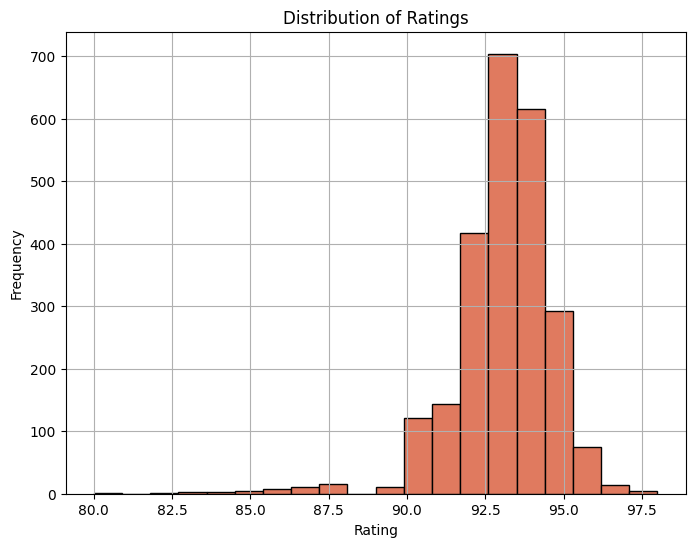

In [12]:
#Visualizing rating

plt.figure(figsize=(8,6))
df['rating'].hist(bins=20, edgecolor='black', color=['#e07a5f'])
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

Let's split combined origins and location to have a clear view

In [13]:
#location
split_loc = df['location'].str.split(",|;", expand = True)

df['loc_country'] = split_loc[1]
df['loc_region'] = split_loc[0]

#origin
split_origin = df['origin'].str.split(",|;", expand = True)
df['origin_1'] = split_origin[0]
df['origin_2'] = split_origin[1]

In [14]:
df.drop(['location', 'origin'], axis = 1)

,rating,roaster,name,roast,est_price,review_date,agtron,desc_1,desc_2,desc_3,loc_country,loc_region,origin_1,origin_2
0,93,Lu's Coffee,Kenya Nyeri Gichathaini AA Top,Medium-Light,NT $320/200 grams,October 2023,58/78,"Richly sweet-savory. Red currant, narcissus, t...",Produced by smallholding members of the Gikand...,"A deep-toned, sweetly savory Kenya cup with in...",Taiwan,New Taipei City,Nyeri growing region,south-central Kenya
1,96,JBC Coffee Roasters,Wilton Benitez Java,Medium-Light,$25.00/8 ounces,October 2023,60/74,"Multi-layered, enigmatic. Tart citrus, myrrh, ...",Produced by Wilton Benitez entirely of the Eth...,"An impossibly complex, delightfully floral car...",Wisconsin,Madison,Piendamó,Cauca
2,94,HWC Coffee Roasters,HWC Holy Melody Espresso Blend,Medium-Light,$40.00/8 ounces,September 2023,57/77,"Evaluated as espresso. Deeply sweet-savory, fr...","A blend of coffees from Kenya and Ethiopia, ro...","A complex, multi-layered espresso blend with n...",Taiwan,Taichung,Kenya,Ethiopia
3,93,HWC Coffee Roasters,HWC Power Drum Espresso Blend,Medium-Light,$40.00/8 ounces,September 2023,58/73,"Evaluated as espresso. Richly chocolaty, sweet...","A blend of coffees from Peru and Guatemala, ro...","A bold, chocolaty espresso blend supported by ...",Taiwan,Taichung,Peru,Guatemala
4,92,Speedwell Coffee,El Salvador Monte Verde,Medium-Light,$16.00/12 ounces,September 2023,60/76,"Sweetly bright, rich-toned. Baking chocolate, ...",Produced by Rene Contreras on the family farm ...,A solid El Salvador cup with a crisp chocolate...,Massachusetts,Plymouth,Monte Verde,Santa Ana Department
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2435,94,JBC Coffee Roasters,Kariru Kenya,Medium-Light,$19.50/12 ounces,October 2018,56/75,"Delicate, richly sweet-savory. Toffee, tamarin...","Despite grower discontent, contested governmen...","A rich, savory-leaning Kenya cup with a vivid ...",Wisconsin,Madison,South-central Kenya,None
2436,96,Dragonfly Coffee Roasters,Esmeralda Estate Porton Geisha Natural,Medium-Light,$75.00/8 ounces,October 2018,56/84,"Rich-toned, cleanly fruit-forward, intricately...",This exceptional coffee was selected as the No...,"A harmonious, refined, exquisitely clean natur...",Colorado,Boulder,Boquete growing region,western Panama
2437,94,Revel Coffee,Kenya Kiambu,Medium-Light,$16.75/12 ounces,October 2018,53/81,"Deeply sweet, richly savory. Red currant, lave...",This coffee earned the second-highest rating i...,"A classically appealing Kenya cup: juicy, swee...",Montana,Billings,Kiambu County,south-central Kenya
2438,93,Big Creek Coffee Roasters,Kenya Gatuya,Medium,$17.00/12 ounces,October 2018,50/70,"Crisply sweet, richly cocoa-toned. Dark chocol...",This coffee tied for the third-highest rating ...,"A complex, chocolaty and floral Kenya cup with...",Montana,Hamilton,South-central Kenya,None


In [15]:
#determine the number of regions
print(df['loc_region'].nunique())

281


In [16]:
#determine the number of countries
print(f"Number of countries: {df['loc_country'].nunique()}")
print(df['loc_country'].unique())

Number of countries: 92
[' Taiwan' ' Wisconsin' ' Massachusetts' " Hawai'i" ' California' ' Maine'
 ' Kansas' ' Thailand' ' Hawai’i' ' Washington' ' Oregon' ' Florida'
 ' Texas' ' New Mexico' ' Colorado' ' Hawaii' ' Virginia' ' Illinois'
 ' Montana' ' Guatemala' ' Puerto Rico' ' China' ' North Carolina'
 ' New Jersey' " Big Island of Hawai'i" ' Big Island of Hawai’i'
 ' United Arab Emirates' ' Vermont' ' Georgia' ' Mexico' ' Nevada'
 ' Idaho' ' Wyoming' ' Nantou' ' South Korea' ' Ohio' ' Utah'
 '  California' ' Arizona' ' Minnesota' ' England' ' New York'
 ' Connecticut' ' Alaska' ' Colorado ' ' Japan' ' Canada' ' Taichung'
 ' New Taipei City' ' Virginia ' ' Hawaii ' ' Michigan' ' Oklahoma'
 ' Sabah' ' Taipei City' ' Calfornia' None ' Kenya' ' New Hampshire'
 ' Pennsylvania' ' Alabama' ' Chia-yi' ' D.C.' ' Oregon ' ' Colombia'
 ' Maui' ' Tennessee' ' Quebec' ' Ontario' ' Saskatchewan' ' Honduras'
 ' Satipo Province' ' Kauai' ' British Columbia' ' Missouri' ' Alberta'
 ' Iowa' ' Mississ

If you check out the countries a little more detailed, it is obvious to see that most of the countries are actually states of Mexico, USA, and Canada. What's more? The list have typos (Hawai'i, MInnesota, etc.) We can use the library named fuzzywuzzy, inspired [from](https://www.kaggle.com/code/schmoyote/coffee-tales-cleaning-dataframe-with-pandas) to transform misspelled words

In [17]:
region = df['loc_region']
country = df['loc_country']

In [18]:
#To begin with, remove the spaces at the beginning and ending, lowercase all the strings
def fic(df, col):
    #lowercase
    df[col] = df[col].str.lower()
    
    #remove space
    df[col] =  df[col].str.strip()
        #remove "'"
    df[col] = df[col].str.replace("'", "")
    df[col] = df[col].str.replace("’", "")
    #capitalize each word
    df[col] = df[col].str.title()


In [19]:
fic(df, "loc_country")

print(f"Number of unique countries: {country.nunique()}")

Number of unique countries: 92


In [20]:
fic(df, "loc_region")
print(f"Number of unique regions: {region.nunique()}")

Number of unique regions: 281


In [21]:
#use fuzzywuzzy
matches = fuzzywuzzy.process.extract("Taipei", 
                                     country, 
                                     limit=10, 
                                     scorer=fuzzywuzzy.fuzz.token_sort_ratio)

matches

[(' Taipei City', 71, 708),
 (' New Taipei City', 57, 570),
 (' Maine', 55, 10),
 (' Maine', 55, 11),
 (' Maine', 55, 93),
 (' Maine', 55, 108),
 (' Maine', 55, 178),
 (' Maine', 55, 186),
 (' Maine', 55, 299),
 (' Maine', 55, 301)]

In [22]:
#Let's create a function that will find us matches and pass some of the countries that were misspelled, so it can fix them for us.

def replace_matches_in_column(df, column, string_to_match, min_ratio = 55):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match

In [23]:
df['loc_country'].unique()

array(['Taiwan', 'Wisconsin', 'Massachusetts', 'Hawaii', 'California',
       'Maine', 'Kansas', 'Thailand', 'Washington', 'Oregon', 'Florida',
       'Texas', 'New Mexico', 'Colorado', 'Virginia', 'Illinois',
       'Montana', 'Guatemala', 'Puerto Rico', 'China', 'North Carolina',
       'New Jersey', 'Big Island Of Hawaii', 'United Arab Emirates',
       'Vermont', 'Georgia', 'Mexico', 'Nevada', 'Idaho', 'Wyoming',
       'Nantou', 'South Korea', 'Ohio', 'Utah', 'Arizona', 'Minnesota',
       'England', 'New York', 'Connecticut', 'Alaska', 'Japan', 'Canada',
       'Taichung', 'New Taipei City', 'Michigan', 'Oklahoma', 'Sabah',
       'Taipei City', 'Calfornia', None, 'Kenya', 'New Hampshire',
       'Pennsylvania', 'Alabama', 'Chia-Yi', 'D.C.', 'Colombia', 'Maui',
       'Tennessee', 'Quebec', 'Ontario', 'Saskatchewan', 'Honduras',
       'Satipo Province', 'Kauai', 'British Columbia', 'Missouri',
       'Alberta', 'Iowa', 'Mississippi', 'Maryland', 'Virginia And Floyd',
       'Was

We can still see different spellings for Hawaii(Big Island of Hawai’i), Washington(Washingto, D.C.), Taipei/New Taipei, let's pass the values to the function

In [24]:
titles_to_replace = ["Washington", "Hawaii"]
for i in titles_to_replace :
    replace_matches_in_column(df, "loc_country", i)
    
print(df['loc_country'].nunique())
print(df['loc_country'].unique())

80
['Taiwan' 'Wisconsin' 'Massachusetts' 'Hawaii' 'California' 'Maine'
 'Kansas' 'Thailand' 'Washington' 'Oregon' 'Florida' 'Texas' 'New Mexico'
 'Colorado' 'Virginia' 'Illinois' 'Montana' 'Guatemala' 'Puerto Rico'
 'China' 'North Carolina' 'New Jersey' 'Big Island Of Hawaii'
 'United Arab Emirates' 'Vermont' 'Georgia' 'Mexico' 'Nevada' 'Idaho'
 'Wyoming' 'Nantou' 'South Korea' 'Ohio' 'Utah' 'Arizona' 'Minnesota'
 'England' 'New York' 'Connecticut' 'Alaska' 'Japan' 'Canada' 'Taichung'
 'New Taipei City' 'Michigan' 'Oklahoma' 'Sabah' 'Taipei City' 'Calfornia'
 None 'Kenya' 'New Hampshire' 'Pennsylvania' 'Alabama' 'Chia-Yi' 'D.C.'
 'Colombia' 'Maui' 'Tennessee' 'Quebec' 'Ontario' 'Saskatchewan'
 'Honduras' 'Satipo Province' 'British Columbia' 'Missouri' 'Alberta'
 'Iowa' 'Mississippi' 'Maryland' 'Virginia And Floyd' 'Belgium' 'Laos'
 'Indonesia' 'Sydney' 'Kauia' 'Oaxaca' 'Slovakia' 'Hong Kong' 'Louisiana'
 'Uganda']


In [25]:
to_replace = {"United States":["Montana", "Pennsylvania","United States And Floyd", "Washington",
                               "Virginia", "Connecticut", "California", "Wisconsin", "Kansas", "Minnesota",
                               "Florida", "Wyoming", "Oregon", "Colorado", "Maine", "Kentucky", "New Hampshire", "New Jersey", "Massachusetts", "North Carolina",
                               "Illinois", "Texas", "Pennsylvania", "New York", "New Mexico", "Idaho", 
                               "Tennessee", "Ohio", "Michigan", "Oklahoma", "Vermont", "Georgia", 
                               "Louisiana", "Mississippi", "Alabama", "Maryland", "Nevada", "Virginia and Floyd", "Iowa", "D.C.", "Missouri", "Oregon", "Alaska", "Arizona", "California", "Virginia", "Colorado", "United States And Floyd"],
             "Hawaii":["Kauai", "Hawai'i", "Maui", "Kauia", "Big Island of Hawaii"],
            "Mexico":["Oaxaca", "Mexico"],
            "Canada":["Ontario", "Nova Scotia", "Quebec", "Saskatchewan", "British Columbia", "Alberta"],
            "Taiwan":["Taiwan", "Taipei City", "Taichung", "New Taipei City", "Nantou", "New Taiwan"],
            "Australia":["Sydney"],
             "Peru":["Satipo Province"],
             "Malaysia":["Sabah"]}

def replace_values(dictionary, df_column):
    for key, value in dictionary.items():
        df_column.replace(value, key, regex=True, inplace=True)

In [26]:
replace_values(to_replace, df.loc_country)

df.loc_country.nunique()

31

In [27]:
df.loc[df.loc_country.isna(), ["loc_country", "loc_region"]]

,loc_country,loc_region
795,None,Taiwan
1019,None,Branford Connecticut
2064,None,Los Angeles


In [28]:
df.at[795, "loc_country"] = "Taiwan"
df.at[1019, "loc_country"] = "United States"
df.at[2064, "loc_country"] = "United States"


In [29]:
df.loc[df.loc_country.isna(), ["loc_country", "loc_region"]]

,loc_country,loc_region


In [30]:
df = df.drop("loc_region", axis=1)

In [31]:
df.loc[:,["origin_1", "origin_2"]]


,origin_1,origin_2
0,Nyeri growing region,south-central Kenya
1,Piendamó,Cauca
2,Kenya,Ethiopia
3,Peru,Guatemala
4,Monte Verde,Santa Ana Department
...,...,...
2435,South-central Kenya,None
2436,Boquete growing region,western Panama
2437,Kiambu County,south-central Kenya
2438,South-central Kenya,None


In [32]:
df["origin_1"].value_counts()

origin_1
Guji Zone                     149
Yirgacheffe growing region    114
Ethiopia                       89
Nyeri growing region           67
Colombia                       56
                             ... 
Maunawili growing region        1
Buesaco                         1
Amaybamba                       1
Brunca growing region           1
Llano Bonito                    1
Name: count, Length: 687, dtype: int64

In [33]:
df["origin_2"].value_counts()

origin_2
 Colombia                        187
 Guatemala                       154
 southern Ethiopia               146
 Oromia Region                   125
 south-central Kenya             112
                                ... 
 Indo-Pacific                      1
 Kerinci                           1
 northern Sumatra Indonesia        1
 Democratic Republic of Congo      1
 Naranjo                           1
Name: count, Length: 372, dtype: int64

In [34]:
cols = ["origin_1", "origin_2"]

for i in cols:
    fic(df, i)

In [35]:
df["origin_2"].fillna(df["origin_1"].shift(), inplace=True)

In [36]:
df = df.drop(["location", "origin"], axis=1)

In [37]:
df['est_price'][:20]

0     NT $320/200 grams
1       $25.00/8 ounces
2       $40.00/8 ounces
3       $40.00/8 ounces
4      $16.00/12 ounces
5     NT $800/200 grams
6      $30.00/12 ounces
7      $24.00/12 ounces
8      $24.00/12 ounces
9      $23.00/12 ounces
10     $20.50/16 ounces
11     $24.50/12 ounces
12      $45.00/4 ounces
13     NT $450/4 ounces
14     $16.50/12 ounces
15     NT $325/8 ounces
16     NT $290/4 ounces
17     NT $280/8 ounces
18     $28.00/10 ounces
19      $20.00/6 ounces
Name: est_price, dtype: object

In [38]:
df["est_price"].isna().sum()

6

In [39]:
df = df.dropna(subset=["est_price"])

In [40]:
# weight measurement


df.loc[df["est_price"].str.contains("grams", case=False), "grams"] = "grams"
df.loc[df["est_price"].str.contains("ounces", case=False), "ounces"] = "ounces"


# currency
df.loc[df["est_price"].str.contains("HKD", case=False), "HKD"] = "HKD"
df.loc[df["est_price"].str.contains("CAD", case=False), "CAD"] = "CAD"
df.loc[df["est_price"].str.contains("NT", case=False), "NT"] = "NT"
df.loc[df["est_price"].str.contains("¥"), "JPY"] = "JPY"
df.loc[df["est_price"].str.contains("€"), "EUR"] = "EUR"
df.loc[df["est_price"].str.contains("£"), "GBP"] = "GBP"

In [41]:
df.loc[:, ["est_price", "grams", "ounces", "HKD", "CAD", "NT", "JPY"]]

,est_price,grams,ounces,HKD,CAD,NT,JPY
0,NT $320/200 grams,grams,NaN,NaN,NaN,NT,NaN
1,$25.00/8 ounces,NaN,ounces,NaN,NaN,NaN,NaN
2,$40.00/8 ounces,NaN,ounces,NaN,NaN,NaN,NaN
3,$40.00/8 ounces,NaN,ounces,NaN,NaN,NaN,NaN
4,$16.00/12 ounces,NaN,ounces,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2435,$19.50/12 ounces,NaN,ounces,NaN,NaN,NaN,NaN
2436,$75.00/8 ounces,NaN,ounces,NaN,NaN,NaN,NaN
2437,$16.75/12 ounces,NaN,ounces,NaN,NaN,NaN,NaN
2438,$17.00/12 ounces,NaN,ounces,NaN,NaN,NaN,NaN


In [42]:
CAD_prices = df.loc[df["CAD"].notna() == True, ["est_price"]]
CAD_prices

,est_price
565,CAD $30.00/250 grams
1415,CAD $18.00/12 ounces
1416,CAD $21.00/12 ounces
1417,CAD $18.00/12 ounces
1418,CAD $21.00/12 ounces
1419,CAD $21.00/12 ounces
1493,CAD $50/200 grams
1494,CAD $45/250 grams
1689,CAD $22.00/225 grams
1693,$19.99 CAD/12 ounces


In [43]:
def clean_df(df, currency, weight):
    #remove the letters and symbols
    df = df.replace(r"[^\d./]+","", regex=True)
    #remove the spaces
    df = df.replace(r" ", "", regex=True)
    #expand the price and weight
    split_df = df["est_price"].str.split("/", expand=True)
    df[currency] = split_df[0]
    df[weight] = split_df[1]
    #drop the est_price column
    df.drop("est_price", axis=1, inplace=True)
    return df

In [44]:
CAD_prices = clean_df(CAD_prices, "CAD", "weight")
CAD_prices[:10]

,CAD,weight
565,30.00,250
1415,18.00,12
1416,21.00,12
1417,18.00,12
1418,21.00,12
1419,21.00,12
1493,50,200
1494,45,250
1689,22.00,225
1693,19.99,12


In [45]:
CAD_prices["grams"] = CAD_prices["weight"].str.extract("([\w]{3})")
CAD_prices

,CAD,weight,grams
565,30.00,250,250
1415,18.00,12,NaN
1416,21.00,12,NaN
1417,18.00,12,NaN
1418,21.00,12,NaN
1419,21.00,12,NaN
1493,50,200,200
1494,45,250,250
1689,22.00,225,225
1693,19.99,12,NaN


In [46]:
CAD_prices["ounces_to_grams"] = CAD_prices["weight"].replace(r"[\w]{3}", 0, regex=True)
CAD_prices["ounces_to_grams"] = CAD_prices["ounces_to_grams"].astype("int") * 28.3
CAD_prices["ounces_to_grams"] = CAD_prices["ounces_to_grams"].replace(0, np.nan, regex=True)
CAD_prices.drop("weight", axis=1, inplace=True)
CAD_prices

,CAD,grams,ounces_to_grams
565,30.00,250,NaN
1415,18.00,NaN,339.6
1416,21.00,NaN,339.6
1417,18.00,NaN,339.6
1418,21.00,NaN,339.6
1419,21.00,NaN,339.6
1493,50,200,NaN
1494,45,250,NaN
1689,22.00,225,NaN
1693,19.99,NaN,339.6


In [47]:
CAD_prices["grams"] = CAD_prices["grams"].fillna(CAD_prices["ounces_to_grams"])
CAD_prices["grams"]
CAD_prices.drop("ounces_to_grams", axis=1, inplace=True)
CAD_prices

,CAD,grams
565,30.00,250
1415,18.00,339.6
1416,21.00,339.6
1417,18.00,339.6
1418,21.00,339.6
1419,21.00,339.6
1493,50,200
1494,45,250
1689,22.00,225
1693,19.99,339.6


In [48]:
CAD_prices["USD_per_gram"] = CAD_prices["CAD"].astype("float").astype("int") / CAD_prices["grams"].astype("float").astype("int") * 0.75
CAD_prices["100g_USD"] = round(CAD_prices["USD_per_gram"] * 100, 2)
CAD_prices.drop(["CAD", "grams", "USD_per_gram"], axis=1, inplace=True)
CAD_prices

,100g_USD
565,9.00
1415,3.98
1416,4.65
1417,3.98
1418,4.65
1419,4.65
1493,18.75
1494,13.50
1689,7.33
1693,4.20


In [49]:
NT_prices = df.loc[df["NT"].notna() == True, ["est_price"]]
NT_prices[:10]

,est_price
0,NT $320/200 grams
5,NT $800/200 grams
13,NT $450/4 ounces
15,NT $325/8 ounces
16,NT $290/4 ounces
17,NT $280/8 ounces
28,NT $480/8 ounces
30,NT $480/100 grams
44,NT $330/8 ounces
46,NT $450/16 ounces


In [50]:
NT_prices = clean_df(NT_prices, "NT", "weight")
NT_prices

,NT,weight
0,320,200
5,800,200
13,450,4
15,325,8
16,290,4
...,...,...
2396,600,200
2397,500,200
2403,1450,8
2408,500,8


In [51]:
# separate grams from ounces
NT_prices["grams"] = NT_prices["weight"].str.extract("([\w]{3})")
# replace 3-digit values with 0 in the ounces column
NT_prices["ounces_to_grams"] = NT_prices["weight"].replace(r"[\w]{3}", 0, regex=True)

In [52]:
def ounces_to_grams(df, column):
    # convert ounces to grams by multiplying it by 28.3
    df["ounces_to_grams"] = df[column].astype("float") * 28.3
    # turn all 0 values to np.nan
    df["ounces_to_grams"] = df["ounces_to_grams"].replace(0, np.nan, regex=True)
    # fill grams column with values from our converted column
    df["grams"] = df["grams"].fillna(df["ounces_to_grams"])
    # drop the unnecessary columns
    df.drop(["ounces_to_grams"], axis=1, inplace=True)
    return df

In [53]:
NT_prices = ounces_to_grams(NT_prices, "ounces_to_grams")
NT_prices

,NT,weight,grams
0,320,200,200
5,800,200,200
13,450,4,113.2
15,325,8,226.4
16,290,4,113.2
...,...,...,...
2396,600,200,200
2397,500,200,200
2403,1450,8,226.4
2408,500,8,226.4


In [54]:
def convert_currency(df, currency, exchange_rate):
    df["USD_per_gram"] = df[currency].astype("float").astype("int") / df["grams"].astype("float").astype("int") * exchange_rate
    df["100g_USD"] = round(df["USD_per_gram"] * 100, 2)
    df.drop([currency, "grams", "USD_per_gram"], axis=1, inplace=True)
    return df

In [55]:
NT_prices = convert_currency(NT_prices, "NT", 0.032)
NT_prices = NT_prices.drop("weight", axis=1)
NT_prices

,100g_USD
0,5.12
5,12.80
13,12.74
15,4.60
16,8.21
...,...
2396,9.60
2397,8.00
2403,20.53
2408,7.08


In [56]:
JPY_prices = df.loc[df["JPY"].notna() == True, ["est_price"]]
JPY_prices

,est_price
1064,¥1680/100 grams
1084,¥88/16 ounces
1085,¥78/16 ounces
1087,¥78/16 ounces
1256,¥2980/100 grams
1305,"¥1,050/100 grams"
1361,¥1280/100 grams
1362,¥1280/100 grams
1363,¥1280/100 grams
1364,¥1280/100 grams


In [57]:
JPY_prices = JPY_prices.drop([1084, 1085, 1087])

In [58]:
def clean_and_exchange(df, currency, weight, exchange_rate):
    cleaned_df = clean_df(df, currency, weight)
    converted_df = convert_currency(cleaned_df, currency, exchange_rate)
    return converted_df


In [59]:
JPY_prices = clean_and_exchange(JPY_prices, "JPY", "grams", 0.0072)
JPY_prices

,100g_USD
1064,12.10
1256,21.46
1305,7.56
1361,9.22
1362,9.22
1363,9.22
1364,9.22
1460,11.38
1461,38.02
1555,8.71


In [60]:
EUR_prices = df.loc[df["EUR"].notna() == True, ["est_price"]]
EUR_prices

,est_price
1980,€29.95/1 kilo (35.3 ounces)


In [61]:
clean_df(EUR_prices, "EUR", "grams")

,EUR,grams
1980,29.95,135.3


In [62]:
# remove the letters and special symbols
EUR_prices = EUR_prices.replace(r"[A-Za-z$¥£€#*;(),-]","", regex=True)
# separate price from weight
split_df = EUR_prices["est_price"].str.split("/", expand=True)
# use the price column only 
EUR_prices["EUR"] = split_df[0]
# find the cost of 1g of coffee in USD by dividing it by our weight (1000g) and multiplying it by the exchange rate
EUR_prices["USD_per_gram"] = EUR_prices["EUR"].astype("float").astype("int") / 1000 * 1.04
# multiply the result by 100 and round it up to get price for 100g
EUR_prices["100g_USD"] = round(EUR_prices["USD_per_gram"] * 100, 2)
# drop the unnecessary columns
EUR_prices.drop(["est_price", "EUR", "USD_per_gram"], axis=1, inplace=True)

In [63]:
EUR_prices

,100g_USD
1980,3.02


In [64]:
GBP_prices = df.loc[df["GBP"].notna() == True, ["est_price"]]
GBP_prices

,est_price
424,£11.15/250 grams
705,£50/10 capsules
1007,£100/150-gram packet
1121,£25.00/8 18-gram pouches
1237,£50/10 capsules
1640,£45/10 capsules
1872,£50.00/10 capsules
2164,£40.50/10 capsules


In [65]:
GBP_prices["name"] = df.loc[df["GBP"].notna() == True, ["name"]]
GBP_prices

,est_price,name
424,£11.15/250 grams,Cafe Granja La Esperanza Natural
705,£50/10 capsules,Esmeralda Estate Panama Geisha
1007,£100/150-gram packet,Hacienda La Esmeralda Montañas 71AS
1121,£25.00/8 18-gram pouches,Bait Alal Community
1237,£50/10 capsules,Esmeralda Estate Panama Geisha
1640,£45/10 capsules,Esmeralda Estate Panama Geisha
1872,£50.00/10 capsules,Esmeralda Estate Panama Geisha
2164,£40.50/10 capsules,Cup of Excellence Rwanda Champion


In [66]:
GBP_prices = clean_df(GBP_prices, "GBP", "grams")
GBP_prices.drop("name", axis = 1, inplace= True)
GBP_prices

,GBP,grams
424,11.15,250
705,50,10
1007,100,150
1121,25.00,818
1237,50,10
1640,45,10
1872,50.00,10
2164,40.50,10


In [67]:
GBP_prices.loc[GBP_prices["grams"] == "10", "grams"] = 54
GBP_prices.loc[GBP_prices["grams"] == "818", "grams"] = 144

GBP_prices

,GBP,grams
424,11.15,250
705,50,54
1007,100,150
1121,25.00,144
1237,50,54
1640,45,54
1872,50.00,54
2164,40.50,54


In [68]:
GBP_prices = convert_currency(GBP_prices, "GBP", 1.2)

In [69]:
GBP_prices

,100g_USD
424,5.28
705,111.11
1007,80.00
1121,20.83
1237,111.11
1640,100.00
1872,111.11
2164,88.89


In [70]:
HKD_prices = df.loc[df["HKD"].notna() == True, ["est_price"]]

HKD_prices

,est_price
421,HKD $428/150 grams
422,HKD $428/150 grams
435,HKD $650/150 grams
437,HKD $530/150 grams
438,HKD $350/150 grams
439,HKD $250/150 grams
441,HKD $128/200 grams
443,HKD $498/100 grams
444,HKD $148/200 grams
769,HKD $498/105 grams


In [71]:
HKD_prices = HKD_prices.replace(r"[^\d/]+","", regex=True)
HKD_prices

,est_price
421,428/150
422,428/150
435,650/150
437,530/150
438,350/150
439,250/150
441,128/200
443,498/100
444,148/200
769,498/105


In [72]:
split_HKD = HKD_prices["est_price"].str.split("/", expand=True)
HKD_prices["HKD"] = split_HKD[0].astype("int")
HKD_prices["grams"] = split_HKD[1].astype("int")
HKD_prices

,est_price,HKD,grams
421,428/150,428,150
422,428/150,428,150
435,650/150,650,150
437,530/150,530,150
438,350/150,350,150
439,250/150,250,150
441,128/200,128,200
443,498/100,498,100
444,148/200,148,200
769,498/105,498,105


In [73]:
HKD_prices.drop("est_price", axis=1, inplace=True)

HKD_prices["price_per_gram"] = HKD_prices["HKD"] / HKD_prices["grams"]*0.13
HKD_prices

,HKD,grams,price_per_gram
421,428,150,0.370933
422,428,150,0.370933
435,650,150,0.563333
437,530,150,0.459333
438,350,150,0.303333
439,250,150,0.216667
441,128,200,0.083200
443,498,100,0.647400
444,148,200,0.096200
769,498,105,0.616571


In [74]:
HKD_prices["100g_USD"] = round(HKD_prices["price_per_gram"] * 100, 2)
HKD_prices.drop(["HKD", "grams", "price_per_gram"], axis=1, inplace=True)
HKD_prices

,100g_USD
421,37.09
422,37.09
435,56.33
437,45.93
438,30.33
439,21.67
441,8.32
443,64.74
444,9.62
769,61.66


In [75]:
price_df = pd.concat([JPY_prices, CAD_prices, NT_prices, HKD_prices, GBP_prices, EUR_prices]).sort_index(axis=0)
price_df

,100g_USD
0,5.12
5,12.80
13,12.74
15,4.60
16,8.21
...,...
2397,8.00
2403,20.53
2407,5.62
2408,7.08


In [76]:
ounces = df.loc[df["ounces"].notnull() & (df["CAD"].isnull()) & (df["NT"].isnull()) & (df["EUR"].isnull())]

ounces

,rating,roaster,name,roast,est_price,review_date,agtron,desc_1,desc_2,desc_3,...,origin_1,origin_2,grams,ounces,HKD,CAD,NT,JPY,EUR,GBP
1,96,JBC Coffee Roasters,Wilton Benitez Java,Medium-Light,$25.00/8 ounces,October 2023,60/74,"Multi-layered, enigmatic. Tart citrus, myrrh, ...",Produced by Wilton Benitez entirely of the Eth...,"An impossibly complex, delightfully floral car...",...,Piendamó,Cauca,NaN,ounces,NaN,NaN,NaN,NaN,NaN,NaN
2,94,HWC Coffee Roasters,HWC Holy Melody Espresso Blend,Medium-Light,$40.00/8 ounces,September 2023,57/77,"Evaluated as espresso. Deeply sweet-savory, fr...","A blend of coffees from Kenya and Ethiopia, ro...","A complex, multi-layered espresso blend with n...",...,Kenya,Ethiopia,NaN,ounces,NaN,NaN,NaN,NaN,NaN,NaN
3,93,HWC Coffee Roasters,HWC Power Drum Espresso Blend,Medium-Light,$40.00/8 ounces,September 2023,58/73,"Evaluated as espresso. Richly chocolaty, sweet...","A blend of coffees from Peru and Guatemala, ro...","A bold, chocolaty espresso blend supported by ...",...,Peru,Guatemala,NaN,ounces,NaN,NaN,NaN,NaN,NaN,NaN
4,92,Speedwell Coffee,El Salvador Monte Verde,Medium-Light,$16.00/12 ounces,September 2023,60/76,"Sweetly bright, rich-toned. Baking chocolate, ...",Produced by Rene Contreras on the family farm ...,A solid El Salvador cup with a crisp chocolate...,...,Monte Verde,Santa Ana Department,NaN,ounces,NaN,NaN,NaN,NaN,NaN,NaN
6,93,Paradise Roasters,Robusta Rosso,Light,$30.00/12 ounces,September 2023,64/88,"Complex, richly bittersweet. Pomegranate, hop ...","Produced at Gem Forest Farm, entirely from tre...","A lovely Thailand Robusta, processed experimen...",...,Phu Khaa,Nan Province,NaN,ounces,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2435,94,JBC Coffee Roasters,Kariru Kenya,Medium-Light,$19.50/12 ounces,October 2018,56/75,"Delicate, richly sweet-savory. Toffee, tamarin...","Despite grower discontent, contested governmen...","A rich, savory-leaning Kenya cup with a vivid ...",...,South-Central Kenya,Kirinyaga District,NaN,ounces,NaN,NaN,NaN,NaN,NaN,NaN
2436,96,Dragonfly Coffee Roasters,Esmeralda Estate Porton Geisha Natural,Medium-Light,$75.00/8 ounces,October 2018,56/84,"Rich-toned, cleanly fruit-forward, intricately...",This exceptional coffee was selected as the No...,"A harmonious, refined, exquisitely clean natur...",...,Boquete Growing Region,Western Panama,NaN,ounces,NaN,NaN,NaN,NaN,NaN,NaN
2437,94,Revel Coffee,Kenya Kiambu,Medium-Light,$16.75/12 ounces,October 2018,53/81,"Deeply sweet, richly savory. Red currant, lave...",This coffee earned the second-highest rating i...,"A classically appealing Kenya cup: juicy, swee...",...,Kiambu County,South-Central Kenya,NaN,ounces,NaN,NaN,NaN,NaN,NaN,NaN
2438,93,Big Creek Coffee Roasters,Kenya Gatuya,Medium,$17.00/12 ounces,October 2018,50/70,"Crisply sweet, richly cocoa-toned. Dark chocol...",This coffee tied for the third-highest rating ...,"A complex, chocolaty and floral Kenya cup with...",...,South-Central Kenya,Kiambu County,NaN,ounces,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
ounce_prices = ounces.loc[:, ["est_price"]]
ounce_prices

,est_price
1,$25.00/8 ounces
2,$40.00/8 ounces
3,$40.00/8 ounces
4,$16.00/12 ounces
6,$30.00/12 ounces
...,...
2435,$19.50/12 ounces
2436,$75.00/8 ounces
2437,$16.75/12 ounces
2438,$17.00/12 ounces


In [78]:
# pattern: $ at the beginning of the string, a group of one or more digits with a dot (".") to indicate cents, slash, one or more digits, and the word "ounces"
pattern = r'^\$(\d+\.\d+)/(\d+)\sounces$'

#create a function that returns a boolean if the pattern is matched
def find_match(x):
    return bool(re.findall(pattern, x))

# create a new column with the output of find_match function
ounce_prices["match"] = ounce_prices["est_price"].apply(find_match)

In [79]:
# show only the rows that don't match our pattern
ounce_prices.loc[ounce_prices["match"]==False]

,est_price,match
123,#23.90/12 ounces,False
517,$5/12 ounces,False
527,$10.00 / 8 ounces,False
533,$30.00/ 12 ounces,False
720,$24.50/5.5 ounces,False
815,$17.99/ 12 ounces,False
919,$11.75/10.5 ounces,False
967,$11.75/10.5 ounces,False
968,$11.75/10.5 ounces,False
971,$12.25/10.5 ounces,False


In [80]:
to_remove = [1845, 1913, 1917, 1920, 1953]

ounce_prices.drop(to_remove, axis=0, inplace=True)

In [81]:
pattern = r'^[A-Z]{2,3}'

def find_match(x):
    return bool(re.findall(pattern, x))

ounce_prices["match"] = ounce_prices["est_price"].apply(find_match)
ounce_prices.loc[ounce_prices["match"]==True]

,est_price,match
1581,USD $206.00/8 ounces,True
1582,USD $206.00/8 ounces,True
1672,US $20.00/12 ounces,True


In [82]:
ounce_prices.drop("match", axis=1, inplace=True)

In [83]:
ounce_prices = clean_df(ounce_prices, "USD", "ounces")

In [84]:
def ounces_to_100g(df):
    df["grams"] = df["ounces"].astype("float64") * 28.35
    df["price_per_gram"] = df["USD"].astype("float64") / df["grams"].astype("float64")
    df["100g_USD"] = round(df["price_per_gram"] * 100, 2)
    df.drop(["grams", "ounces", "price_per_gram", "USD"], axis=1, inplace=True)
    return df

In [85]:
ounce_prices = ounces_to_100g(ounce_prices)
ounce_prices

,100g_USD
1,11.02
2,17.64
3,17.64
4,4.70
6,8.82
...,...
2435,5.73
2436,33.07
2437,4.92
2438,5.00


In [86]:
price_df

,100g_USD
0,5.12
5,12.80
13,12.74
15,4.60
16,8.21
...,...
2397,8.00
2403,20.53
2407,5.62
2408,7.08


In [87]:
print(f"Ounce_prices df mean: {ounce_prices.mean()}")
print(f"Price_df mean: {price_df.mean()}")

Ounce_prices df mean: 100g_USD    9.316332
dtype: float64
Price_df mean: 100g_USD    9.857779
dtype: float64


In [88]:
df["loc_country"].unique()

array(['Taiwan', 'United States', 'Hawaii', 'Thailand', 'Guatemala',
       'Puerto Rico', 'China', 'Big Island Of Hawaii',
       'United Arab Emirates', 'Mexico', 'South Korea', 'Utah', 'England',
       'Japan', 'Canada', 'New Taiwan', 'Malaysia', 'Calfornia', 'Kenya',
       'Chia-Yi', 'Colombia', 'Honduras', 'Peru',
       'United States And Floyd', 'Belgium', 'Laos', 'Indonesia',
       'Australia', 'Slovakia', 'Hong Kong', 'Uganda'], dtype=object)

In [89]:
countries = ["China", "Australia", "Thailand", "South Korea", "United Arab Emirates", "Uganda", "Slovakia", "Mexico", "Indonesia", "Laos", "Belgium", "Guatemala", "Peru", "Honduras", "Colombia", "Kenya", "Malaysia"]

df.loc[df["loc_country"].isin(countries), ["est_price","loc_country"]]

,est_price,loc_country
20,$10.00/250 grams,Thailand
21,$5.00/250 grams,Thailand
68,$17.00/12 ounces,Guatemala
69,$30.00/12 ounces,Guatemala
70,$30.00/12 ounces,Guatemala
...,...,...
2298,$28.85/8 ounces,China
2412,$37.00/120 grams,China
2421,$6.00/250 grams,Thailand
2422,$6.00/250 grams,Thailand


In [90]:
AUD_prices = df.loc[[61,678], ["est_price"]]
AUD_prices

,est_price
61,$23.00/12 ounces
678,NT $550/4 ounces


In [91]:
AUD_prices = clean_and_exchange(AUD_prices, "AUD", "grams", 0.69)
AUD_prices

,100g_USD
61,132.25
678,9487.50


In [92]:
Peru_prices = df.loc[[1206,1207], ["est_price"]]
Peru_prices

,est_price
1206,$19.50/12 ounces
1207,$18.00/12 ounces


In [93]:
Peru_prices = clean_and_exchange(Peru_prices, "USD", "grams", 1)
Peru_prices

,100g_USD
1206,158.33
1207,150.00


In [94]:
RM_prices = df.loc[[2069,2070,2071], ["est_price"]]
RM_prices

,est_price
2069,NT $300/8 ounces
2070,$20.99/12 ounces
2071,$100/18 grams


In [95]:
RM_prices = clean_and_exchange(RM_prices, "RM", "grams", 0.23)
RM_prices

,100g_USD
2069,862.50
2070,38.33
2071,127.78


In [96]:
additional_prices = pd.concat([AUD_prices, Peru_prices, RM_prices]).sort_index(axis=0)

In [97]:
all_prices = pd.concat([price_df, ounce_prices, additional_prices]).sort_index(axis=0)
all_prices

,100g_USD
0,5.12
1,11.02
2,17.64
3,17.64
4,4.70
...,...
2435,5.73
2436,33.07
2437,4.92
2438,5.00


In [98]:
clean_df = df.merge(all_prices, left_index=True, right_index=True)
clean_df = clean_df.drop(["est_price", "grams", "ounces", "HKD", "CAD", "NT", "JPY", "EUR", "GBP"], axis=1)
clean_df[:15]

,rating,roaster,name,roast,review_date,agtron,desc_1,desc_2,desc_3,loc_country,origin_1,origin_2,100g_USD
0,93,Lu's Coffee,Kenya Nyeri Gichathaini AA Top,Medium-Light,October 2023,58/78,"Richly sweet-savory. Red currant, narcissus, t...",Produced by smallholding members of the Gikand...,"A deep-toned, sweetly savory Kenya cup with in...",Taiwan,Nyeri Growing Region,South-Central Kenya,5.12
1,96,JBC Coffee Roasters,Wilton Benitez Java,Medium-Light,October 2023,60/74,"Multi-layered, enigmatic. Tart citrus, myrrh, ...",Produced by Wilton Benitez entirely of the Eth...,"An impossibly complex, delightfully floral car...",United States,Piendamó,Cauca,11.02
2,94,HWC Coffee Roasters,HWC Holy Melody Espresso Blend,Medium-Light,September 2023,57/77,"Evaluated as espresso. Deeply sweet-savory, fr...","A blend of coffees from Kenya and Ethiopia, ro...","A complex, multi-layered espresso blend with n...",Taiwan,Kenya,Ethiopia,17.64
3,93,HWC Coffee Roasters,HWC Power Drum Espresso Blend,Medium-Light,September 2023,58/73,"Evaluated as espresso. Richly chocolaty, sweet...","A blend of coffees from Peru and Guatemala, ro...","A bold, chocolaty espresso blend supported by ...",Taiwan,Peru,Guatemala,17.64
4,92,Speedwell Coffee,El Salvador Monte Verde,Medium-Light,September 2023,60/76,"Sweetly bright, rich-toned. Baking chocolate, ...",Produced by Rene Contreras on the family farm ...,A solid El Salvador cup with a crisp chocolate...,United States,Monte Verde,Santa Ana Department,4.70
5,93,GK Coffee,Uganda Sipi Falls Station Anaerobic Natural,Light,September 2023,65/81,"Richly bittersweet, deep-toned. Tangerine zest...",Produced in the Bugisu Region of Uganda near M...,An inviting anaerobic natural Uganda with thro...,Taiwan,Sipi Falls,Bugisu Region,12.80
6,93,Paradise Roasters,Robusta Rosso,Light,September 2023,64/88,"Complex, richly bittersweet. Pomegranate, hop ...","Produced at Gem Forest Farm, entirely from tre...","A lovely Thailand Robusta, processed experimen...",Hawaii,Phu Khaa,Nan Province,8.82
7,93,Jaunt Coffee Roasters,Yirgacheffe Chelbesa Danche,Light,September 2023,65/81,"Sweetly citrusy, cocoa-toned. Lime zest, cocoa...",Produced by the METAD farm and mill in souther...,"A balanced, nuanced washed Ethiopia cup with p...",United States,Chelchele,Gedeb District,7.05
8,92,Jaunt Coffee Roasters,Ethiopia Guji Buku,Light,September 2023,64/78,"Berry-toned, chocolaty. Berry melange, baking ...","Produced by smallholding farmers, from heirloo...",A berry-driven natural-processed Ethiopia — th...,United States,Kebele,Buku Sayisa,7.05
9,93,Jaunt Coffee Roasters,Kenya Nyeri Chinga,Medium-Light,September 2023,60/77,"Brightly sweet, spice-toned. Red currant, nutm...",Produced by smallholding members of the Othaya...,"The bottom line: A balanced, juicy, spice-tone...",United States,Nyeri Growing Region,South-Central Kenya,6.76


In [99]:
clean_df = clean_df[["name", "roaster", "roast", "loc_country", "origin_1", "origin_2", "100g_USD", "rating", "review_date", "desc_1", "desc_2", "desc_3"]]

In [100]:
clean_df.to_csv("coffee_analysis_clean.csv", index=False)